In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import icnn_pytorch_adaptive as icnn
import utils
from itertools import product

In [2]:

ckpt_path = 'logs/soccer_uncons_effort/t_1/checkpoints_dir/model_final.pth'
model_2 = 'logs/soccer_uncons_effort/t_1/checkpoints_dir/model_final.pth'

# ckpt_path = 'logs/soccer_constrained/t_1/checkpoints_dir/model_final.pth'
# model_2 = 'logs/soccer_constrained/t_1/checkpoints_dir/model_final.pth'

activation = 'relu'

model = icnn.SingleBVPNet(in_features=9, out_features=1, type=activation, mode='mlp', hidden_features=72, num_hidden_layers=5, dropout=0)
model2 = icnn.SingleBVPNet(in_features=9, out_features=1, type=activation, mode='mlp', hidden_features=72, num_hidden_layers=5, dropout=0)

checkpoint = torch.load(ckpt_path, map_location=torch.device("cpu"))
c2 = torch.load(model_2, map_location=torch.device("cpu"))

try:
    model_weights = checkpoint['model']
except:
    model_weights = checkpoint

try:
    mw = c2['model']
except:
    mw = c2

model.load_state_dict(model_weights)
model2.load_state_dict(mw)
model.eval()
model2.eval()

SingleBVPNet(
  (net): FCBlock(
    (nl): ReLU(inplace=True)
    (nl_u): ReLU(inplace=True)
    (net_u): ModuleList(
      (0): Sequential(
        (0): Linear(in_features=8, out_features=72, bias=True)
        (1): Dropout(p=0, inplace=False)
      )
      (1): Sequential(
        (0): Linear(in_features=72, out_features=72, bias=True)
        (1): Dropout(p=0, inplace=False)
      )
      (2): Sequential(
        (0): Linear(in_features=72, out_features=72, bias=True)
        (1): Dropout(p=0, inplace=False)
      )
      (3): Sequential(
        (0): Linear(in_features=72, out_features=72, bias=True)
        (1): Dropout(p=0, inplace=False)
      )
      (4): Sequential(
        (0): Linear(in_features=72, out_features=72, bias=True)
        (1): Dropout(p=0, inplace=False)
      )
    )
    (net_zu_u): ModuleList(
      (0): Sequential(
        (0): Linear(in_features=72, out_features=72, bias=True)
        (1): Dropout(p=0, inplace=False)
      )
      (1): Sequential(
        (0)

SingleBVPNet(
  (net): FCBlock(
    (nl): ReLU(inplace=True)
    (nl_u): ReLU(inplace=True)
    (net_u): ModuleList(
      (0): Sequential(
        (0): Linear(in_features=8, out_features=72, bias=True)
        (1): Dropout(p=0, inplace=False)
      )
      (1): Sequential(
        (0): Linear(in_features=72, out_features=72, bias=True)
        (1): Dropout(p=0, inplace=False)
      )
      (2): Sequential(
        (0): Linear(in_features=72, out_features=72, bias=True)
        (1): Dropout(p=0, inplace=False)
      )
      (3): Sequential(
        (0): Linear(in_features=72, out_features=72, bias=True)
        (1): Dropout(p=0, inplace=False)
      )
      (4): Sequential(
        (0): Linear(in_features=72, out_features=72, bias=True)
        (1): Dropout(p=0, inplace=False)
      )
    )
    (net_zu_u): ModuleList(
      (0): Sequential(
        (0): Linear(in_features=72, out_features=72, bias=True)
        (1): Dropout(p=0, inplace=False)
      )
      (1): Sequential(
        (0)

In [3]:
g1 = utils.GOAL_1
g2 = utils.GOAL_2

G = [g1, g2]

# G = [(0.1, 0), (-0.1, 0)]

X = torch.zeros((100, 8))
X[:, 0] = 0.0
X[:, 1] = 0.0
X[:, 4] = 0.25
X[:, 5] = 0.0
p_T = torch.linspace(0, 1, 100).reshape(-1, 1)


X = torch.cat((X, p_T), dim=1)
dt = 0.1
t_1 = 0.1

# X_in = torch.cat((X[:, 0].reshape(-1, 1), X[:, -1].reshape(-1, 1)), dim=1)
X_in = {'coords': X.to(torch.float32)}
v2 = model(X_in)['model_out'].detach().cpu().numpy()

In [4]:
## check min max value for t = T - delta t
delta_t = 0.1
V1 = []
t = t_1 - delta_t
actions = []
u_low = -2
u_high = 2
d_low = -1
d_high = 1
values = []
inst_terms = []
# X = torch.tensor([[t, delta_x, delta_v]], dtype=torch.float32)
for p in torch.linspace(0, 1, 100):
    X = torch.zeros((1, 8))
    X[:, 0] = 0.0
    X[:, 1] = 0.0
    X[:, 4] = 0.25
    X[:, 5] = 0.0
    p_T = torch.linspace(0, 1, 81).reshape(-1, 1)
    p_T[:, ] = p

    x_next = utils.point_dyn(X, u_high, d_high)

    X_next = torch.from_numpy(utils.make_pairs(x_next[:, :4], x_next[:, 4:8]))
    X_next_p = torch.cat((X_next, p_T), dim=1).to(torch.float32)
    if t_1 == 0.1:
        V_next = utils.final_cost(X_next[:, :2], X_next[:, 4:6], G, p.detach().numpy(), game='uncons')
    else:
        V_next = model2({'coords': X_next_p})['model_out'].detach().numpy()

    V_next = np.vstack(V_next).reshape(9, 9)
    V_next = np.min(np.max(V_next, 1))

    V1.append(V_next)

In [5]:
p = p_T.numpy()
points = zip(V1, p)
from utils_refactor import cav_vex

In [6]:
ps = np.linspace(0, 1, 100)
vex = []
for p in ps:
    vex.append(cav_vex(V1, p, type='vex', num_ps=100))

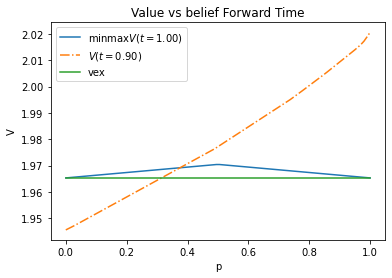

In [7]:
plt.plot(np.linspace(0, 1, 100), V1, label=f'$\min \max V(t={1 - t:.2f})$')
plt.plot(np.linspace(0, 1, 100), v2, '-.', label=f'$V(t={1-(t+delta_t):.2f})$')
plt.plot(np.linspace(0, 1, 100), vex, label='vex')

plt.title('Value vs belief Forward Time')
plt.xlabel('p')
plt.ylabel('V')
plt.legend()
# plt.ylim([-0.5, 0.5])
plt.rcParams['figure.figsize'] = (8, 6)

In [71]:
x1 = np.array([1, -1, 0, 0])
x2 = np.zeros((4, ))
g1 = utils.GOAL_1
g2 = utils.GOAL_2

G = [g1, g2]
curr_x = np.hstack((x1, x2))
umax = 2
dmax = 1
X_new = utils.point_dyn(np.expand_dims(curr_x, axis=0), umax, dmax, dt=0.1)
x_new = utils.make_pairs(X_new[:, :4], X_new[:, 4:8])

In [72]:
p_next_1 = 0.5 * np.ones((81, 1))
val = utils.final_cost(x_new[:, :2], x_new[:, 4:6], G, p_next_1, game='uncons').reshape(9, 9)

In [73]:
val

array([[0.61530289, 0.61530289, 0.61530289, 0.61531539, 0.61531539,
        0.61531539, 0.61530289, 0.61530289, 0.61530289],
       [0.61079438, 0.61079438, 0.61079438, 0.61080688, 0.61080688,
        0.61080688, 0.61079438, 0.61079438, 0.61079438],
       [0.60634079, 0.60634079, 0.60634079, 0.60635329, 0.60635329,
        0.60635329, 0.60634079, 0.60634079, 0.60634079],
       [0.62252085, 0.62252085, 0.62252085, 0.62253335, 0.62253335,
        0.62253335, 0.62252085, 0.62252085, 0.62252085],
       [0.61802149, 0.61802149, 0.61802149, 0.61803399, 0.61803399,
        0.61803399, 0.61802149, 0.61802149, 0.61802149],
       [0.6135766 , 0.6135766 , 0.6135766 , 0.6135891 , 0.6135891 ,
        0.6135891 , 0.6135766 , 0.6135766 , 0.6135766 ],
       [0.62975667, 0.62975667, 0.62975667, 0.62976917, 0.62976917,
        0.62976917, 0.62975667, 0.62975667, 0.62975667],
       [0.62526648, 0.62526648, 0.62526648, 0.62527898, 0.62527898,
        0.62527898, 0.62526648, 0.62526648, 0.62526648],


In [74]:
np.min(np.max(val, 1)), np.argmin(np.max(val, 1))

(0.6063532862616423, 2)

In [75]:
val_w_effort = utils.final_cost(x_new[:, :2], x_new[:, 4:6], G, p_next_1, game='uncons').reshape(9, 9) + 0.1 * utils.inst_cost(umax, dmax, 0.01, 0.01).reshape(9, 9)

In [76]:
np.min(np.max(val_w_effort, 1)), np.argmin(np.max(val_w_effort, 1)), np.min(np.max(val, 1))

(0.6143532862616423, 2, 0.6063532862616423)